#### Импортируем необходимые нам библиотеки

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

#### Загружаем наши данные

In [33]:
data = pd.read_excel("train.xlsx", parse_dates=["dt"], index_col="dt")
data.columns = ["price"]

#### Смотрим на даные

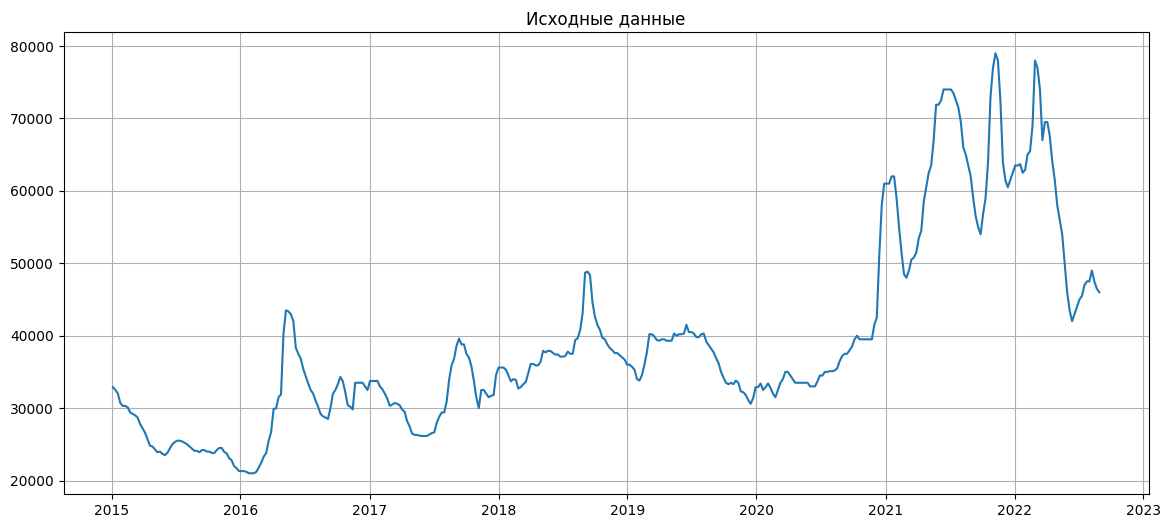

In [34]:
plt.figure(figsize=(14, 6))
plt.plot(data, label="Цена на арматуру")
plt.title("Исходные данные")
plt.grid()
plt.show()


#### Смотрим на страционарность

In [35]:
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Критические значения:')
    for k, v in result[4].items():
        print(f'{k}: {v}')
    
check_stationarity(data['price'])

ADF Statistic: -1.9258699893713453
p-value: 0.3199906102569917
Критические значения:
1%: -3.4470566389664703
5%: -2.8689037160476016
10%: -2.570692663557422


ряд не стационарный

In [36]:
data['price_diff'] = data['price'].diff(periods=1)
data_diff = data['price_diff'].dropna()
check_stationarity(data_diff)

ADF Statistic: -7.7060615041152065
p-value: 1.3006938373810178e-11
Критические значения:
1%: -3.447405233596701
5%: -2.8690569369014605
10%: -2.5707743450830893


Теперь ряд стационарный

#### Теперь делаем декомпозицыю

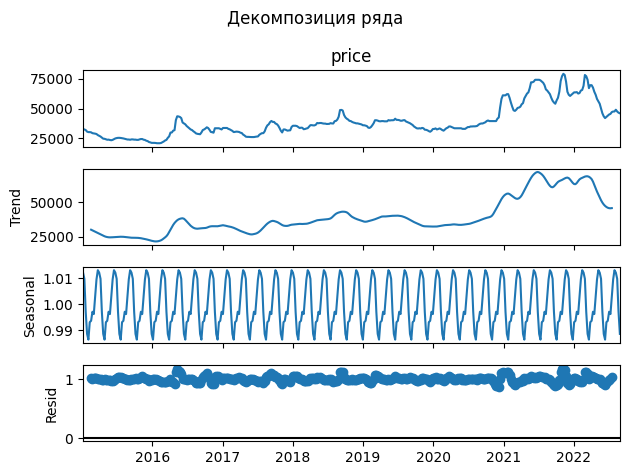

In [37]:
decomposition = seasonal_decompose(data['price'], model='multiplicative', period=12)
decomposition.plot()
plt.suptitle("Декомпозиция ряда")
plt.tight_layout()
plt.show()

#### Теперь делим данные

In [38]:
train = data.iloc[:-30]
test = data.iloc[-30:]

Создаем лаги и доп данные также обучаем модель

In [39]:
def create_features(df):
    features = df.copy()
    for lag in [1, 2, 4, 8, 12]:
        features[f'lag_{lag}'] = features['price'].shift(lag)
    features['rolling_mean_4'] = features['price'].rolling(4).mean()
    features['rolling_std_12'] = features['price'].rolling(12).std()
    features['month'] = features.index.month
    features['year'] = features.index.year
    return features.dropna()

train_feat = create_features(train.copy())
test_feat = create_features(test.copy())

required_features = ['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 
                   'rolling_mean_4', 'rolling_std_12',
                   'month', 'year']

X_train = train_feat[required_features]
y_train = train_feat['price']
X_test = test_feat[required_features]
y_test = test_feat['price']

xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.01,
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

#### Смотрим на данные 


4. Результаты:


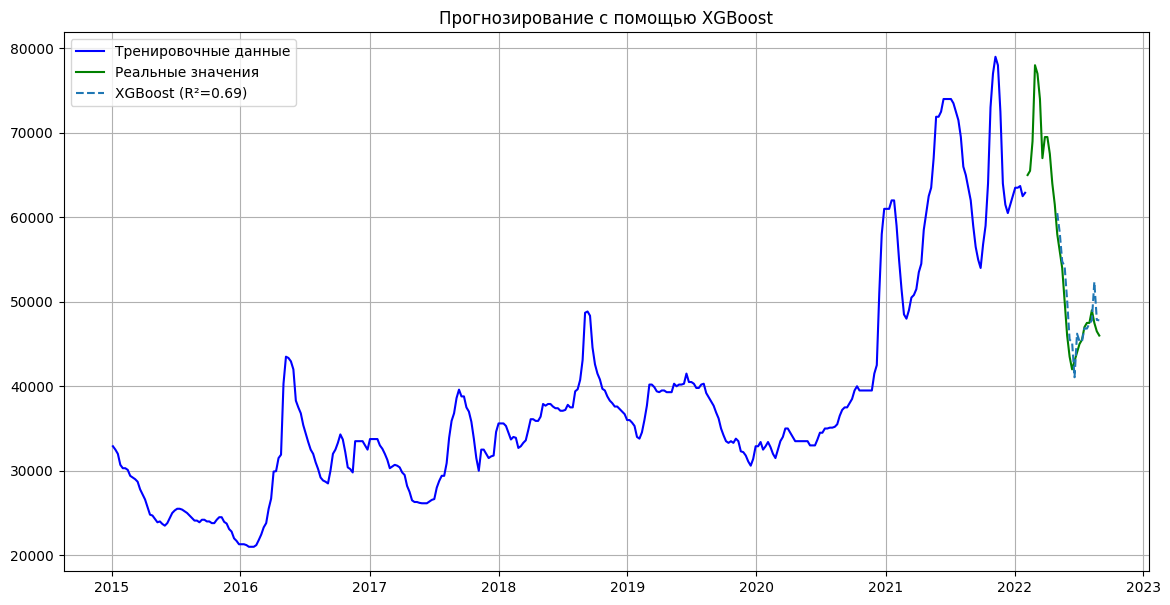

In [ ]:
xgb_forecast = xgb_model.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_forecast)
plt.figure(figsize=(14,7))
plt.plot(train.index, train['price'], label='Тренировочные данные', color='blue')
plt.plot(test.index, test['price'], label='Реальные значения', color='green')
plt.plot(test_feat.index, xgb_forecast, label=f'XGBoost (R²={xgb_r2:.2f})', linestyle='--')
plt.title('Прогнозирование с помощью XGBoost')
plt.legend()
plt.grid()
plt.show()

#### подготавливаем все для прогноза и выводим прогноз

In [ ]:

last_date = data.index[-1]
future_dates = pd.date_range(last_date, periods=30, freq='W')
future_data = pd.DataFrame(index=future_dates)
last_values = data.tail(12).copy()

for i in range(30):
    temp_df = pd.concat([last_values, future_data.iloc[:i]], axis=0)
    for lag in [1, 2, 4, 8, 12]:
        future_data.loc[future_dates[i], f'lag_{lag}'] = temp_df['price'].shift(lag).iloc[-1]
    future_data.loc[future_dates[i], 'rolling_mean_4'] = temp_df['price'].rolling(4).mean().iloc[-1]
    future_data.loc[future_dates[i], 'rolling_std_12'] = temp_df['price'].rolling(12).std().iloc[-1]
    future_data.loc[future_dates[i], 'month'] = future_dates[i].month
    future_data.loc[future_dates[i], 'year'] = future_dates[i].year

forecast = xgb_model.predict(future_data[required_features])


plt.figure(figsize=(14,7))
plt.plot(data.index, data['price'], label='Исторические данные', color='blue')
plt.plot(future_dates, forecast, label='Прогноз на 30 недель', color='red', linestyle='--')
plt.title('Прогноз цен на следующие 30 недель')
plt.legend()
plt.grid()
plt.show()